In [ ]:
# models: BERT, RoBERTa, DistilBERT, ALBERT, ModernBERT, DeBERTa

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 39.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 22.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 23.2 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.0
    Uninstalling fsspec-2025.3.0:
      Successfully uninstalled fsspec-2025.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from functools import partial
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, precision_recall_fscore_support, roc_curve, auc, precision_recall_curve, average_precision_score, classification_report, confusion_matrix
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.utils.class_weight import compute_class_weight

from datasets import Dataset, DatasetDict
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, EarlyStoppingCallback, DataCollatorWithPadding, TrainerCallback


In [2]:
import warnings
warnings.filterwarnings('ignore')
import gc

In [ ]:
train_df = pd.read_excel('/content/drive/Shareddrives/FYP 2024-2025/Phase-2/Wiki_WikiBias/detection/train.xlsx') # 58-42 percent class balance
val_df = pd.read_excel('/content/drive/Shareddrives/FYP 2024-2025/Phase-2/Wiki_WikiBias/detection/dev.xlsx') # 60-40 percent class balance
test_df = pd.read_excel('/content/drive/Shareddrives/FYP 2024-2025/Phase-2/Wiki_WikiBias/detection/test.xlsx') # 60-40 percent class balance

train_df.rename(columns={'bias_label': 'labels'}, inplace=True)
val_df.rename(columns={'bias_label': 'labels'}, inplace=True)
test_df.rename(columns={'bias_label': 'labels'}, inplace=True)

train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)
test_dataset = Dataset.from_pandas(test_df)

dataset = DatasetDict({
    "train": train_dataset,
    "val": val_dataset,
    "test": test_dataset
})

labels = [label for label in dataset["train"]["labels"]]  # Extract all labels from training set
class_weights = compute_class_weight(class_weight="balanced", classes=np.array([0, 1]), y=labels)
class_weights = torch.tensor(class_weights, dtype=torch.float32)

In [ ]:
# define custom trainer class: weighted loss
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels")
        # forward pass
        outputs = model(**inputs)
        logits = outputs.get("logits")
        loss_fct = nn.CrossEntropyLoss(weight=class_weights).to("cuda" if torch.cuda.is_available() else "cpu")
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

In [ ]:
train_bsz, val_bsz = 8, 8
n_epochs = 10
lr = 5e-5

In [ ]:
# function to tokenize input text
def tokenize_function(examples, input_col, hf_tokenizer):
    tokenized = hf_tokenizer(examples[input_col], truncation=True, max_length=256, padding="max_length")
    return tokenized

# print loss, acc, prec, recall, f1 every epoch
def compute_metrics(eval_pred):
    labels = eval_pred.label_ids  # True labels
    pred_labels = np.argmax(eval_pred.predictions, axis=1)  # Model predictions

    acc = accuracy_score(labels, pred_labels)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, pred_labels, average='binary')

    return {"accuracy": acc, "precision": precision, "recall": recall, "f1": f1}


class MetricsCallback(TrainerCallback):
    def __init__(self):
        self.training_history = {"train": [], "eval": []}

    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs is not None:
            if "loss" in logs:  # Training logs
                self.training_history["train"].append(logs)
            elif "eval_loss" in logs:  # Evaluation logs
                self.training_history["eval"].append(logs)

# cleanup function
def cleanup(things_to_delete: list | None = None):
    if things_to_delete is not None:
        for thing in things_to_delete:
            if thing is not None:
                del thing

    gc.collect()
    torch.cuda.empty_cache()

In [ ]:
def finetune(checkpoint: str, output_dir:str, dataset, num_labels: int = 2, weighted:bool = True, do_cleanup:bool=True):
  # initialize tokenizer
  hf_tokenizer = AutoTokenizer.from_pretrained(checkpoint)

  # tokenize dataset
  tokenized_dataset = dataset.map(partial(tokenize_function, input_col="sentence", hf_tokenizer=hf_tokenizer), batched=True)

  # initialize model
  hf_model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=num_labels)

  hf_data_collator = DataCollatorWithPadding(tokenizer=hf_tokenizer)

  # define training arguments
  training_args = TrainingArguments(
      output_dir=output_dir,
      learning_rate=lr,
      per_device_train_batch_size=train_bsz,
      per_device_eval_batch_size=val_bsz,
      gradient_accumulation_steps=4,
      num_train_epochs=n_epochs,
      lr_scheduler_type="linear",
      optim="adamw_torch",
      logging_strategy="epoch",
      eval_strategy="epoch",
      save_strategy="epoch",
      load_best_model_at_end=True,
      push_to_hub=False,
      report_to="none"
  )

  # define trainer
  if weighted:
    trainer = CustomTrainer(
      model=hf_model,
      args=training_args,
      train_dataset=tokenized_dataset["train"],
      eval_dataset=tokenized_dataset["val"],
      tokenizer=hf_tokenizer,
      compute_metrics=compute_metrics,
      data_collator=hf_data_collator,
      callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
    )
  else:
    trainer = Trainer(
      model=hf_model,
      args=training_args,
      train_dataset=tokenized_dataset["train"],
      eval_dataset=tokenized_dataset["val"],
      tokenizer=hf_tokenizer,
      compute_metrics=compute_metrics,
      data_collator=hf_data_collator,
      callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
    )

  # Add callback to trainer
  metrics_callback = MetricsCallback()
  trainer.add_callback(metrics_callback)

  # Train model
  trainer.train()

  # Get the training results
  train_history_df = pd.DataFrame(metrics_callback.training_history["train"])
  train_history_df = train_history_df.add_prefix("train_")
  eval_history_df = pd.DataFrame(metrics_callback.training_history["eval"])
  train_res_df = pd.concat([train_history_df, eval_history_df], axis=1)

  # Evaluate model on the test set and return results
  test_dataset = tokenized_dataset["test"]
  test_results = trainer.evaluate(test_dataset)

  pred = trainer.predict(test_dataset)
  y_pred = torch.argmax(torch.tensor(pred.predictions), axis=1).numpy()
  y_true = pred.label_ids

  classif_report = classification_report(y_true, y_pred, output_dict=True)
  classif_report_df = pd.DataFrame(classif_report).transpose()

  conf_matrix = confusion_matrix(y_true, y_pred)
  conf_matrix_df = pd.DataFrame(conf_matrix, columns=["Predicted Non-Biased", "Predicted Biased"], index=["Actual Non-Biased", "Actual Biased"])

  if do_cleanup:
    cleanup(things_to_delete=[trainer, hf_model, hf_tokenizer, tokenized_dataset, dataset])

  return train_res_df, test_results, classif_report_df, conf_matrix_df, hf_model, hf_tokenizer

# BERT

In [ ]:
train_res_df, test_results, classif_report_df, conf_matrix_df, hf_model, hf_tokenizer = finetune(checkpoint='bert-base-uncased', output_dir='/content/drive/Shareddrives/FYP 2024-2025/Phase-2/Lexical Bias Detection/Wiki/model_checkpoints/BERT', dataset=dataset, num_labels=2, do_cleanup=True)

Map:   0%|          | 0/5028 [00:00<?, ? examples/s]

Map:   0%|          | 0/1066 [00:00<?, ? examples/s]

Map:   0%|          | 0/2104 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.684600,0.611672,0.670732,0.588889,0.614849,0.601589
2,0.614100,0.594380,0.662289,0.566355,0.703016,0.627329
3,0.526900,0.635311,0.577861,0.488257,0.916473,0.637097
4,0.433000,0.630095,0.663227,0.566667,0.709977,0.630278
5,0.331800,0.756036,0.684803,0.596741,0.679814,0.635575


In [ ]:
train_res_df # Training logs

,train_loss,train_grad_norm,train_learning_rate,train_epoch,eval_loss,eval_accuracy,eval_precision,eval_recall,eval_f1
0,0.6846,2.640748,0.000045,1.0,0.611672,0.670732,0.588889,0.614849,0.601589
1,0.6141,1.896812,0.000040,2.0,0.594380,0.662289,0.566355,0.703016,0.627329
2,0.5269,1.322730,0.000035,3.0,0.635311,0.577861,0.488257,0.916473,0.637097
3,0.4330,1.969245,0.000030,4.0,0.630095,0.663227,0.566667,0.709977,0.630278
4,0.3318,0.732386,0.000025,5.0,0.756036,0.684803,0.596741,0.679814,0.635575


In [ ]:
print(':: Results on Test Set ::')
print(test_results)

:: Results on Test Set ::
{'eval_loss': 0.5995551347732544, 'eval_accuracy': 0.6549429657794676, 'eval_precision': 0.5577981651376147, 'eval_recall': 0.7136150234741784, 'eval_f1': 0.6261585993820803, 'eval_runtime': 32.2, 'eval_samples_per_second': 65.342, 'eval_steps_per_second': 8.168, 'epoch': 5.0}


In [ ]:
classif_report_df

,precision,recall,f1-score,support
0,0.759369,0.615016,0.679612,1252.000000
1,0.557798,0.713615,0.626159,852.000000
accuracy,0.654943,0.654943,0.654943,0.654943
macro avg,0.658584,0.664315,0.652885,2104.000000
weighted avg,0.677744,0.654943,0.657966,2104.000000


In [ ]:
conf_matrix_df

,Predicted Non-Biased,Predicted Biased
Actual Non-Biased,770,482
Actual Biased,244,608


In [ ]:
# Save best model for inference
hf_model.save_pretrained('/content/drive/Shareddrives/FYP 2024-2025/Phase-2/Lexical Bias Detection/Wiki/saved_models/BERT')
hf_tokenizer.save_pretrained('/content/drive/Shareddrives/FYP 2024-2025/Phase-2/Lexical Bias Detection/Wiki/saved_models/BERT')

('/content/drive/Shareddrives/FYP 2024-2025/Phase-2/Lexical Bias Detection/Wiki/saved_models/BERT/tokenizer_config.json',
 '/content/drive/Shareddrives/FYP 2024-2025/Phase-2/Lexical Bias Detection/Wiki/saved_models/BERT/special_tokens_map.json',
 '/content/drive/Shareddrives/FYP 2024-2025/Phase-2/Lexical Bias Detection/Wiki/saved_models/BERT/vocab.txt',
 '/content/drive/Shareddrives/FYP 2024-2025/Phase-2/Lexical Bias Detection/Wiki/saved_models/BERT/added_tokens.json',
 '/content/drive/Shareddrives/FYP 2024-2025/Phase-2/Lexical Bias Detection/Wiki/saved_models/BERT/tokenizer.json')

In [ ]:
del hf_model, hf_tokenizer

# RoBERTa

In [ ]:
lr = 2e-5 # for RoBERTa, best results are obtained with this LR

In [ ]:
train_res_df, test_results, classif_report_df, conf_matrix_df, hf_model, hf_tokenizer = finetune(checkpoint='FacebookAI/roberta-base', output_dir='/content/drive/Shareddrives/FYP 2024-2025/Phase-2/Lexical Bias Detection/Wiki/model_checkpoints/RoBERTa', dataset=dataset, num_labels=2, do_cleanup=True)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Map:   0%|          | 0/5028 [00:00<?, ? examples/s]

Map:   0%|          | 0/1066 [00:00<?, ? examples/s]

Map:   0%|          | 0/2104 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.681600,0.625935,0.645403,0.541997,0.793503,0.644068
2,0.610900,0.594157,0.689493,0.604167,0.672854,0.636663
3,0.542000,0.638210,0.673546,0.571924,0.765661,0.654762
4,0.496900,0.595253,0.689493,0.594697,0.728538,0.654849
5,0.434300,0.587171,0.711069,0.648910,0.621810,0.635071
6,0.388500,0.680114,0.673546,0.572935,0.756381,0.652000
7,0.343500,0.712321,0.688555,0.597633,0.703016,0.646055
8,0.307500,0.726309,0.691370,0.602823,0.693735,0.645092


In [ ]:
train_res_df # Training logs

,train_loss,train_grad_norm,train_learning_rate,train_epoch,eval_loss,eval_accuracy,eval_precision,eval_recall,eval_f1
0,0.6816,7.281956,0.000018,1.0,0.625935,0.645403,0.541997,0.793503,0.644068
1,0.6109,3.734139,0.000016,2.0,0.594157,0.689493,0.604167,0.672854,0.636663
2,0.5420,5.274104,0.000014,3.0,0.638210,0.673546,0.571924,0.765661,0.654762
3,0.4969,8.897946,0.000012,4.0,0.595253,0.689493,0.594697,0.728538,0.654849
4,0.4343,2.774848,0.000010,5.0,0.587171,0.711069,0.648910,0.621810,0.635071
5,0.3885,1.071458,0.000008,6.0,0.680114,0.673546,0.572935,0.756381,0.652000
6,0.3435,4.645429,0.000006,7.0,0.712321,0.688555,0.597633,0.703016,0.646055
7,0.3075,0.716358,0.000004,8.0,0.726309,0.691370,0.602823,0.693735,0.645092


In [ ]:
print(':: Results on Test Set ::')
print(test_results)

:: Results on Test Set ::
{'eval_loss': 0.6313725113868713, 'eval_accuracy': 0.7115019011406845, 'eval_precision': 0.659297789336801, 'eval_recall': 0.5950704225352113, 'eval_f1': 0.6255397902529303, 'eval_runtime': 29.4543, 'eval_samples_per_second': 71.433, 'eval_steps_per_second': 8.929, 'epoch': 8.0}


In [ ]:
classif_report_df

,precision,recall,f1-score,support
0,0.741573,0.790735,0.765365,1252.000000
1,0.659298,0.595070,0.625540,852.000000
accuracy,0.711502,0.711502,0.711502,0.711502
macro avg,0.700435,0.692903,0.695453,2104.000000
weighted avg,0.708256,0.711502,0.708744,2104.000000


In [ ]:
# Save best model for inference
hf_model.save_pretrained('/content/drive/Shareddrives/FYP 2024-2025/Phase-2/Lexical Bias Detection/Wiki/saved_models/RoBERTa')
hf_tokenizer.save_pretrained('/content/drive/Shareddrives/FYP 2024-2025/Phase-2/Lexical Bias Detection/Wiki/saved_models/RoBERTa')

('/content/drive/Shareddrives/FYP 2024-2025/Phase-2/Lexical Bias Detection/Wiki/saved_models/RoBERTa/tokenizer_config.json',
 '/content/drive/Shareddrives/FYP 2024-2025/Phase-2/Lexical Bias Detection/Wiki/saved_models/RoBERTa/special_tokens_map.json',
 '/content/drive/Shareddrives/FYP 2024-2025/Phase-2/Lexical Bias Detection/Wiki/saved_models/RoBERTa/vocab.json',
 '/content/drive/Shareddrives/FYP 2024-2025/Phase-2/Lexical Bias Detection/Wiki/saved_models/RoBERTa/merges.txt',
 '/content/drive/Shareddrives/FYP 2024-2025/Phase-2/Lexical Bias Detection/Wiki/saved_models/RoBERTa/added_tokens.json',
 '/content/drive/Shareddrives/FYP 2024-2025/Phase-2/Lexical Bias Detection/Wiki/saved_models/RoBERTa/tokenizer.json')

In [ ]:
del hf_model, hf_tokenizer

# ModernBERT

In [ ]:
train_res_df, test_results, classif_report_df, conf_matrix_df, hf_model, hf_tokenizer = finetune(checkpoint='answerdotai/ModernBERT-base', output_dir='/content/drive/Shareddrives/FYP 2024-2025/Phase-2/Lexical Bias Detection/Wiki/model_checkpoints/ModernBERT', dataset=dataset, num_labels=2, do_cleanup=True)

tokenizer_config.json:   0%|          | 0.00/20.8k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.13M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/694 [00:00<?, ?B/s]

Map:   0%|          | 0/5028 [00:00<?, ? examples/s]

Map:   0%|          | 0/1066 [00:00<?, ? examples/s]

Map:   0%|          | 0/2104 [00:00<?, ? examples/s]

config.json:   0%|          | 0.00/1.19k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/599M [00:00<?, ?B/s]

Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,2.784500,0.658419,0.600375,0.504488,0.651972,0.568826
2,2.575600,0.656700,0.588180,0.494490,0.832947,0.620570
3,2.308600,0.674834,0.567542,0.481481,0.904872,0.628525
4,1.969600,0.609521,0.689493,0.626904,0.573086,0.598788
5,1.539600,0.721717,0.687617,0.648485,0.496520,0.562418
6,1.156400,0.940700,0.663227,0.575314,0.638051,0.605061
7,0.793300,1.271170,0.681989,0.597046,0.656613,0.625414


In [ ]:
train_res_df # Training logs

,train_loss,train_grad_norm,train_learning_rate,train_epoch,eval_loss,eval_accuracy,eval_precision,eval_recall,eval_f1
0,2.7845,12.644593,0.000018,1.0,0.658419,0.600375,0.504488,0.651972,0.568826
1,2.5756,2.825791,0.000016,2.0,0.656700,0.588180,0.494490,0.832947,0.620570
2,2.3086,4.464979,0.000014,3.0,0.674834,0.567542,0.481481,0.904872,0.628525
3,1.9696,12.119587,0.000012,4.0,0.609521,0.689493,0.626904,0.573086,0.598788
4,1.5396,8.472533,0.000010,5.0,0.721717,0.687617,0.648485,0.496520,0.562418
5,1.1564,0.997068,0.000008,6.0,0.940700,0.663227,0.575314,0.638051,0.605061
6,0.7933,14.106825,0.000006,7.0,1.271170,0.681989,0.597046,0.656613,0.625414


In [ ]:
print(':: Results on Test Set ::')
print(test_results)

:: Results on Test Set ::
{'eval_loss': 0.6298158168792725, 'eval_accuracy': 0.6658745247148289, 'eval_precision': 0.5946632782719187, 'eval_recall': 0.5492957746478874, 'eval_f1': 0.5710799267846248, 'eval_runtime': 45.8133, 'eval_samples_per_second': 45.925, 'eval_steps_per_second': 5.741, 'epoch': 7.0}


In [ ]:
classif_report_df

,precision,recall,f1-score,support
0,0.708428,0.745208,0.726353,1252.000000
1,0.594663,0.549296,0.571080,852.000000
accuracy,0.665875,0.665875,0.665875,0.665875
macro avg,0.651546,0.647252,0.648716,2104.000000
weighted avg,0.662360,0.665875,0.663476,2104.000000


In [ ]:
conf_matrix_df

,Predicted Non-Biased,Predicted Biased
Actual Non-Biased,933,319
Actual Biased,384,468


In [ ]:
# Save best model for inference
hf_model.save_pretrained('/content/drive/Shareddrives/FYP 2024-2025/Phase-2/Lexical Bias Detection/Wiki/saved_models/ModernBERT')
hf_tokenizer.save_pretrained('/content/drive/Shareddrives/FYP 2024-2025/Phase-2/Lexical Bias Detection/Wiki/saved_models/ModernBERT')

('/content/drive/Shareddrives/FYP 2024-2025/Phase-2/Lexical Bias Detection/Wiki/saved_models/ModernBERT/tokenizer_config.json',
 '/content/drive/Shareddrives/FYP 2024-2025/Phase-2/Lexical Bias Detection/Wiki/saved_models/ModernBERT/special_tokens_map.json',
 '/content/drive/Shareddrives/FYP 2024-2025/Phase-2/Lexical Bias Detection/Wiki/saved_models/ModernBERT/tokenizer.json')

In [ ]:
del hf_model, hf_tokenizer

# DistilBERT

In [ ]:
lr = 2e-5

In [ ]:
train_res_df, test_results, classif_report_df, conf_matrix_df, hf_model, hf_tokenizer = finetune(checkpoint='distilbert-base-uncased', output_dir='/content/drive/Shareddrives/FYP 2024-2025/Phase-2/Lexical Bias Detection/Wiki/model_checkpoints/DistilBERT', dataset=dataset, num_labels=2, do_cleanup=True)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/5028 [00:00<?, ? examples/s]

Map:   0%|          | 0/1066 [00:00<?, ? examples/s]

Map:   0%|          | 0/2104 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.676000,0.615852,0.672608,0.607330,0.538283,0.570726
2,0.588200,0.590543,0.678236,0.594017,0.645012,0.618465
3,0.505800,0.593658,0.667917,0.565365,0.772622,0.652941
4,0.429400,0.618725,0.685741,0.602128,0.656613,0.628191
5,0.353700,0.707772,0.692308,0.629073,0.582367,0.604819


In [ ]:
train_res_df # Training logs

,train_loss,train_grad_norm,train_learning_rate,train_epoch,eval_loss,eval_accuracy,eval_precision,eval_recall,eval_f1
0,0.6760,2.119022,0.000018,1.0,0.615852,0.672608,0.607330,0.538283,0.570726
1,0.5882,1.424963,0.000016,2.0,0.590543,0.678236,0.594017,0.645012,0.618465
2,0.5058,1.496417,0.000014,3.0,0.593658,0.667917,0.565365,0.772622,0.652941
3,0.4294,1.988287,0.000012,4.0,0.618725,0.685741,0.602128,0.656613,0.628191
4,0.3537,1.600555,0.000010,5.0,0.707772,0.692308,0.629073,0.582367,0.604819


In [ ]:
print(':: Results on Test Set ::')
print(test_results)

:: Results on Test Set ::
{'eval_loss': 0.5912906527519226, 'eval_accuracy': 0.6696768060836502, 'eval_precision': 0.5867403314917127, 'eval_recall': 0.6232394366197183, 'eval_f1': 0.6044393853158794, 'eval_runtime': 15.9034, 'eval_samples_per_second': 132.299, 'eval_steps_per_second': 16.537, 'epoch': 5.0}


In [ ]:
classif_report_df

,precision,recall,f1-score,support
0,0.732277,0.701278,0.716442,1252.000000
1,0.586740,0.623239,0.604439,852.000000
accuracy,0.669677,0.669677,0.669677,0.669677
macro avg,0.659509,0.662259,0.660441,2104.000000
weighted avg,0.673343,0.669677,0.671087,2104.000000


In [ ]:
conf_matrix_df

,Predicted Non-Biased,Predicted Biased
Actual Non-Biased,878,374
Actual Biased,321,531


# ALBERT

In [ ]:
lr = 2e-5

In [ ]:
train_res_df, test_results, classif_report_df, conf_matrix_df, hf_model, hf_tokenizer = finetune(checkpoint='albert/albert-base-v2', output_dir='/content/drive/Shareddrives/FYP 2024-2025/Phase-2/Lexical Bias Detection/Wiki/model_checkpoints/ALBERT', dataset=dataset, num_labels=2, do_cleanup=True)

Map:   0%|          | 0/5028 [00:00<?, ? examples/s]

Map:   0%|          | 0/1066 [00:00<?, ? examples/s]

Map:   0%|          | 0/2104 [00:00<?, ? examples/s]

Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert/albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.677800,0.627340,0.662289,0.575693,0.626450,0.600000
2,0.605300,0.613196,0.645403,0.541471,0.802784,0.646729
3,0.551100,0.644319,0.630394,0.527489,0.823666,0.643116
4,0.489900,0.629217,0.652908,0.550082,0.777262,0.644231
5,0.397400,0.743651,0.685741,0.626316,0.552204,0.586930


In [ ]:
train_res_df

,train_loss,train_grad_norm,train_learning_rate,train_epoch,eval_loss,eval_accuracy,eval_precision,eval_recall,eval_f1
0,0.6778,10.490882,0.000018,1.0,0.627340,0.662289,0.575693,0.626450,0.600000
1,0.6053,9.083415,0.000016,2.0,0.613196,0.645403,0.541471,0.802784,0.646729
2,0.5511,4.382515,0.000014,3.0,0.644319,0.630394,0.527489,0.823666,0.643116
3,0.4899,9.365100,0.000012,4.0,0.629217,0.652908,0.550082,0.777262,0.644231
4,0.3974,30.859797,0.000010,5.0,0.743651,0.685741,0.626316,0.552204,0.586930


In [ ]:
print(':: Results on Test Set ::')
print(test_results)

:: Results on Test Set ::
{'eval_loss': 0.6084378361701965, 'eval_accuracy': 0.6254752851711026, 'eval_precision': 0.525, 'eval_recall': 0.7887323943661971, 'eval_f1': 0.6303939962476548, 'eval_runtime': 35.0691, 'eval_samples_per_second': 59.996, 'eval_steps_per_second': 7.499, 'epoch': 5.0}


In [ ]:
classif_report_df

,precision,recall,f1-score,support
0,0.781553,0.514377,0.620424,1252.000000
1,0.525000,0.788732,0.630394,852.000000
accuracy,0.625475,0.625475,0.625475,0.625475
macro avg,0.653277,0.651555,0.625409,2104.000000
weighted avg,0.677664,0.625475,0.624461,2104.000000


In [ ]:
conf_matrix_df

,Predicted Non-Biased,Predicted Biased
Actual Non-Biased,644,608
Actual Biased,180,672


In [ ]:
# Save best model for inference
hf_model.save_pretrained('/content/drive/Shareddrives/FYP 2024-2025/Phase-2/Lexical Bias Detection/Wiki/saved_models/ALBERT')
hf_tokenizer.save_pretrained('/content/drive/Shareddrives/FYP 2024-2025/Phase-2/Lexical Bias Detection/Wiki/saved_models/ALBERT')

('/content/drive/Shareddrives/FYP 2024-2025/Phase-2/Lexical Bias Detection/Wiki/saved_models/ALBERT/tokenizer_config.json',
 '/content/drive/Shareddrives/FYP 2024-2025/Phase-2/Lexical Bias Detection/Wiki/saved_models/ALBERT/special_tokens_map.json',
 '/content/drive/Shareddrives/FYP 2024-2025/Phase-2/Lexical Bias Detection/Wiki/saved_models/ALBERT/spiece.model',
 '/content/drive/Shareddrives/FYP 2024-2025/Phase-2/Lexical Bias Detection/Wiki/saved_models/ALBERT/added_tokens.json',
 '/content/drive/Shareddrives/FYP 2024-2025/Phase-2/Lexical Bias Detection/Wiki/saved_models/ALBERT/tokenizer.json')

In [ ]:
del hf_model, hf_tokenizer

# DeBERTa-v3-base

In [ ]:
lr = 2e-5

In [ ]:
train_res_df, test_results, classif_report_df, conf_matrix_df, hf_model, hf_tokenizer = finetune(checkpoint='microsoft/deberta-v3-base', output_dir='/content/drive/Shareddrives/FYP 2024-2025/Phase-2/Lexical Bias Detection/Wiki/model_checkpoints/DeBERTa', dataset=dataset, num_labels=2, do_cleanup=True)

tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

Map:   0%|          | 0/5028 [00:00<?, ? examples/s]

Map:   0%|          | 0/1066 [00:00<?, ? examples/s]

Map:   0%|          | 0/2104 [00:00<?, ? examples/s]

pytorch_model.bin:   0%|          | 0.00/371M [00:00<?, ?B/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/371M [00:00<?, ?B/s]

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.674600,0.628429,0.681051,0.655290,0.445476,0.530387
2,0.592700,0.573526,0.701689,0.604436,0.758701,0.672840
3,0.511700,0.587932,0.696998,0.593426,0.795824,0.679881
4,0.442900,0.570906,0.725141,0.651316,0.689095,0.669673
5,0.376900,0.634730,0.740150,0.711538,0.600928,0.651572
6,0.309800,0.674064,0.716698,0.624758,0.749420,0.681435
7,0.259900,0.717317,0.717636,0.630522,0.728538,0.675996


In [ ]:
train_res_df

,train_loss,train_grad_norm,train_learning_rate,train_epoch,eval_loss,eval_accuracy,eval_precision,eval_recall,eval_f1
0,0.6746,1.446654,0.000018,1.0,0.628429,0.681051,0.655290,0.445476,0.530387
1,0.5927,1.204551,0.000016,2.0,0.573526,0.701689,0.604436,0.758701,0.672840
2,0.5117,1.554439,0.000014,3.0,0.587932,0.696998,0.593426,0.795824,0.679881
3,0.4429,1.206235,0.000012,4.0,0.570906,0.725141,0.651316,0.689095,0.669673
4,0.3769,0.794803,0.000010,5.0,0.634730,0.740150,0.711538,0.600928,0.651572
5,0.3098,2.851590,0.000008,6.0,0.674064,0.716698,0.624758,0.749420,0.681435
6,0.2599,5.682585,0.000006,7.0,0.717317,0.717636,0.630522,0.728538,0.675996


In [ ]:
print(':: Results on Test Set ::')
print(test_results)

:: Results on Test Set ::
{'eval_loss': 0.6089147329330444, 'eval_accuracy': 0.7096007604562737, 'eval_precision': 0.6406067677946324, 'eval_recall': 0.6443661971830986, 'eval_f1': 0.6424809830310123, 'eval_runtime': 42.0951, 'eval_samples_per_second': 49.982, 'eval_steps_per_second': 6.248, 'epoch': 7.0}


In [ ]:
classif_report_df

,precision,recall,f1-score,support
0,0.757017,0.753994,0.755502,1252.000000
1,0.640607,0.644366,0.642481,852.000000
accuracy,0.709601,0.709601,0.709601,0.709601
macro avg,0.698812,0.699180,0.698992,2104.000000
weighted avg,0.709877,0.709601,0.709735,2104.000000


In [ ]:
conf_matrix_df

,Predicted Non-Biased,Predicted Biased
Actual Non-Biased,944,308
Actual Biased,303,549


In [ ]:
# Save best model for inference
hf_model.save_pretrained('/content/drive/Shareddrives/FYP 2024-2025/Phase-2/Lexical Bias Detection/Wiki/saved_models/DeBERTa')
hf_tokenizer.save_pretrained('/content/drive/Shareddrives/FYP 2024-2025/Phase-2/Lexical Bias Detection/Wiki/saved_models/DeBERTa')

('/content/drive/Shareddrives/FYP 2024-2025/Phase-2/Lexical Bias Detection/Wiki/saved_models/DeBERTa/tokenizer_config.json',
 '/content/drive/Shareddrives/FYP 2024-2025/Phase-2/Lexical Bias Detection/Wiki/saved_models/DeBERTa/special_tokens_map.json',
 '/content/drive/Shareddrives/FYP 2024-2025/Phase-2/Lexical Bias Detection/Wiki/saved_models/DeBERTa/spm.model',
 '/content/drive/Shareddrives/FYP 2024-2025/Phase-2/Lexical Bias Detection/Wiki/saved_models/DeBERTa/added_tokens.json',
 '/content/drive/Shareddrives/FYP 2024-2025/Phase-2/Lexical Bias Detection/Wiki/saved_models/DeBERTa/tokenizer.json')

In [ ]:
del hf_model, hf_tokenizer

# ROC and Precision-Recall Curves

In [6]:
# Tokenization function
def tokenize_function(examples, input_col, hf_tokenizer):
    tokenized = hf_tokenizer(examples[input_col], truncation=True, max_length=256, padding="max_length")
    return tokenized

In [7]:
test_df = pd.read_excel('/content/drive/Shareddrives/FYP 2024-2025/Phase-2/Wiki_WikiBias/detection/test.xlsx')
test_df.rename(columns={'bias_label': 'labels'}, inplace=True)
test_df.columns

Index(['sentence', 'labels', 'bias_tags'], dtype='object')

In [8]:
test_df = test_df[['sentence', 'labels']]
test_dataset = Dataset.from_pandas(test_df, preserve_index=False)


In [8]:
checkpoint = '/content/drive/Shareddrives/FYP 2024-2025/Phase-2/Lexical Bias Detection/Wiki/saved_models/BERT'
bert_tokenizer = AutoTokenizer.from_pretrained(checkpoint)
bert_model = AutoModelForSequenceClassification.from_pretrained(checkpoint)

In [9]:
tokenized_test = test_dataset.map(partial(tokenize_function, input_col="sentence", hf_tokenizer=bert_tokenizer), batched=True)

Map:   0%|          | 0/2104 [00:00<?, ? examples/s]

In [10]:
bert_model.eval()
bert_model.to('cuda')


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [11]:
# Extract labels and predictions
y_true = test_df['labels'].values
tokenized_inputs = {key: torch.tensor(val).to("cuda") for key, val in tokenized_test.to_dict().items() if key not in ["sentence", "labels"]}

with torch.no_grad():
    logits = bert_model(**tokenized_inputs).logits.cpu().numpy()

y_scores = F.softmax(torch.tensor(logits), dim=1)[:, 1].numpy()

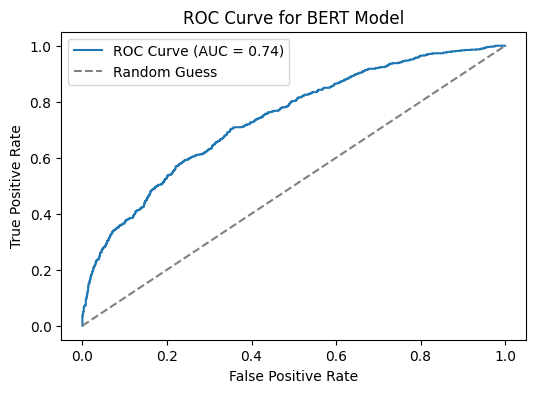

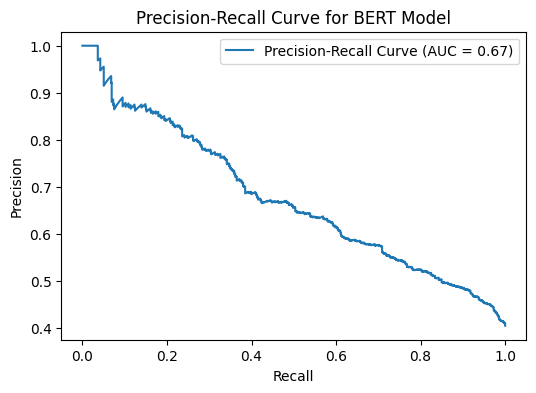

In [12]:
# Compute ROC curve
bert_fpr, bert_tpr, _ = roc_curve(y_true, y_scores)
bert_roc_auc = auc(bert_fpr, bert_tpr)

# Compute Precision-Recall curve
bert_precision, bert_recall, _ = precision_recall_curve(y_true, y_scores)
bert_auc_pr = auc(bert_recall, bert_precision)


# Plot ROC Curve
plt.figure(figsize=(6, 4))
plt.plot(bert_fpr, bert_tpr, label=f'ROC Curve (AUC = {bert_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guess')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for BERT Model")
plt.legend()
plt.show()

# Plot Precision-Recall Curve
plt.figure(figsize=(6, 4))
plt.plot(bert_recall, bert_precision, label=f'Precision-Recall Curve (AUC = {bert_auc_pr:.2f})')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve for BERT Model")
plt.legend()
plt.show()


In [13]:
# prompt: save all bert roc and prc related values as a json/dictionary file in drive

import json

# Create a dictionary to store the ROC and PRC values
bert_metrics = {
    "roc_fpr": bert_fpr.tolist(),
    "roc_tpr": bert_tpr.tolist(),
    "roc_auc": bert_roc_auc,
    "prc_precision": bert_precision.tolist(),
    "prc_recall": bert_recall.tolist(),
    "prc_auc": bert_auc_pr
}

# Specify the file path in your Google Drive
file_path = "/content/drive/Shareddrives/FYP 2024-2025/Phase-2/Lexical Bias Detection/Wiki/saved_models/BERT.json"

# Save the dictionary as a JSON file
with open(file_path, "w") as f:
    json.dump(bert_metrics, f)


In [6]:
checkpoint = '/content/drive/Shareddrives/FYP 2024-2025/Phase-2/Lexical Bias Detection/Wiki/saved_models/RoBERTa'
roberta_tokenizer = AutoTokenizer.from_pretrained(checkpoint)
roberta_model = AutoModelForSequenceClassification.from_pretrained(checkpoint)

In [7]:
tokenized_test = test_dataset.map(partial(tokenize_function, input_col="sentence", hf_tokenizer=roberta_tokenizer), batched=True)

Map:   0%|          | 0/2104 [00:00<?, ? examples/s]

In [8]:
roberta_model.eval()
roberta_model.to('cuda')


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

In [9]:
# Extract labels and predictions
y_true = test_df['labels'].values
tokenized_inputs = {key: torch.tensor(val).to("cuda") for key, val in tokenized_test.to_dict().items() if key not in ["sentence", "labels"]}

with torch.no_grad():
    logits = roberta_model(**tokenized_inputs).logits.cpu().numpy()

y_scores = F.softmax(torch.tensor(logits), dim=1)[:, 1].numpy()

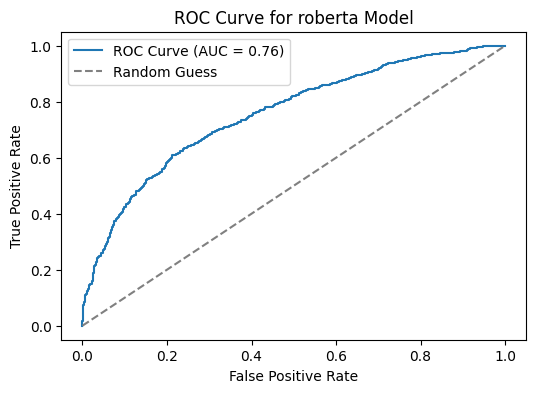

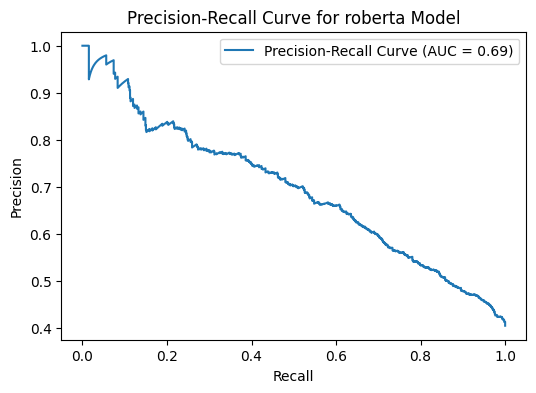

In [10]:
# Compute ROC curve
roberta_fpr, roberta_tpr, _ = roc_curve(y_true, y_scores)
roberta_roc_auc = auc(roberta_fpr, roberta_tpr)

# Compute Precision-Recall curve
roberta_precision, roberta_recall, _ = precision_recall_curve(y_true, y_scores)
roberta_auc_pr = auc(roberta_recall, roberta_precision)


# Plot ROC Curve
plt.figure(figsize=(6, 4))
plt.plot(roberta_fpr, roberta_tpr, label=f'ROC Curve (AUC = {roberta_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guess')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for roberta Model")
plt.legend()
plt.show()

# Plot Precision-Recall Curve
plt.figure(figsize=(6, 4))
plt.plot(roberta_recall, roberta_precision, label=f'Precision-Recall Curve (AUC = {roberta_auc_pr:.2f})')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve for roberta Model")
plt.legend()
plt.show()


In [11]:
# prompt: save all roberta roc and prc related values as a json/dictionary file in drive

import json

# Create a dictionary to store the ROC and PRC values
roberta_metrics = {
    "roc_fpr": roberta_fpr.tolist(),
    "roc_tpr": roberta_tpr.tolist(),
    "roc_auc": roberta_roc_auc,
    "prc_precision": roberta_precision.tolist(),
    "prc_recall": roberta_recall.tolist(),
    "prc_auc": roberta_auc_pr
}

# Specify the file path in your Google Drive
file_path = "/content/drive/Shareddrives/FYP 2024-2025/Phase-2/Lexical Bias Detection/Wiki/saved_models/RoBERTa.json"

# Save the dictionary as a JSON file
with open(file_path, "w") as f:
    json.dump(roberta_metrics, f)


In [12]:
checkpoint = '/content/drive/Shareddrives/FYP 2024-2025/Phase-2/Lexical Bias Detection/Wiki/saved_models/DistilBERT'
distilbert_tokenizer = AutoTokenizer.from_pretrained(checkpoint)
distilbert_model = AutoModelForSequenceClassification.from_pretrained(checkpoint)

In [13]:
tokenized_test = test_dataset.map(partial(tokenize_function, input_col="sentence", hf_tokenizer=distilbert_tokenizer), batched=True)

Map:   0%|          | 0/2104 [00:00<?, ? examples/s]

In [14]:
distilbert_model.eval()
distilbert_model.to('cuda')


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [15]:
# Extract labels and predictions
y_true = test_df['labels'].values
tokenized_inputs = {key: torch.tensor(val).to("cuda") for key, val in tokenized_test.to_dict().items() if key not in ["sentence", "labels"]}

with torch.no_grad():
    logits = distilbert_model(**tokenized_inputs).logits.cpu().numpy()

y_scores = F.softmax(torch.tensor(logits), dim=1)[:, 1].numpy()

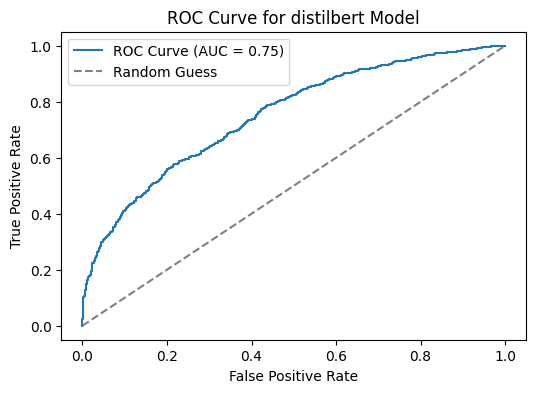

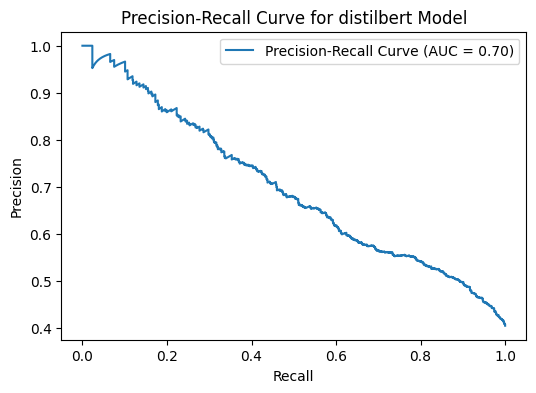

In [16]:
# Compute ROC curve
distilbert_fpr, distilbert_tpr, _ = roc_curve(y_true, y_scores)
distilbert_roc_auc = auc(distilbert_fpr, distilbert_tpr)

# Compute Precision-Recall curve
distilbert_precision, distilbert_recall, _ = precision_recall_curve(y_true, y_scores)
distilbert_auc_pr = auc(distilbert_recall, distilbert_precision)


# Plot ROC Curve
plt.figure(figsize=(6, 4))
plt.plot(distilbert_fpr, distilbert_tpr, label=f'ROC Curve (AUC = {distilbert_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guess')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for distilbert Model")
plt.legend()
plt.show()

# Plot Precision-Recall Curve
plt.figure(figsize=(6, 4))
plt.plot(distilbert_recall, distilbert_precision, label=f'Precision-Recall Curve (AUC = {distilbert_auc_pr:.2f})')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve for distilbert Model")
plt.legend()
plt.show()


In [17]:
# prompt: save all distilbert roc and prc related values as a json/dictionary file in drive

import json

# Create a dictionary to store the ROC and PRC values
distilbert_metrics = {
    "roc_fpr": distilbert_fpr.tolist(),
    "roc_tpr": distilbert_tpr.tolist(),
    "roc_auc": distilbert_roc_auc,
    "prc_precision": distilbert_precision.tolist(),
    "prc_recall": distilbert_recall.tolist(),
    "prc_auc": distilbert_auc_pr
}

# Specify the file path in your Google Drive
file_path = "/content/drive/Shareddrives/FYP 2024-2025/Phase-2/Lexical Bias Detection/Wiki/saved_models/DistilBERT.json"

# Save the dictionary as a JSON file
with open(file_path, "w") as f:
    json.dump(distilbert_metrics, f)


In [18]:
checkpoint = '/content/drive/Shareddrives/FYP 2024-2025/Phase-2/Lexical Bias Detection/Wiki/saved_models/ModernBERT'
modernbert_tokenizer = AutoTokenizer.from_pretrained(checkpoint)
modernbert_model = AutoModelForSequenceClassification.from_pretrained(checkpoint)

In [19]:
tokenized_test = test_dataset.map(partial(tokenize_function, input_col="sentence", hf_tokenizer=modernbert_tokenizer), batched=True)

Map:   0%|          | 0/2104 [00:00<?, ? examples/s]

In [20]:
modernbert_model.eval()
modernbert_model.to('cuda')


ModernBertForSequenceClassification(
  (model): ModernBertModel(
    (embeddings): ModernBertEmbeddings(
      (tok_embeddings): Embedding(50368, 768, padding_idx=50283)
      (norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (drop): Dropout(p=0.0, inplace=False)
    )
    (layers): ModuleList(
      (0): ModernBertEncoderLayer(
        (attn_norm): Identity()
        (attn): ModernBertAttention(
          (Wqkv): Linear(in_features=768, out_features=2304, bias=False)
          (rotary_emb): ModernBertRotaryEmbedding()
          (Wo): Linear(in_features=768, out_features=768, bias=False)
          (out_drop): Identity()
        )
        (mlp_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): ModernBertMLP(
          (Wi): Linear(in_features=768, out_features=2304, bias=False)
          (act): GELUActivation()
          (drop): Dropout(p=0.0, inplace=False)
          (Wo): Linear(in_features=1152, out_features=768, bias=False)
        )
      

In [21]:
# Extract labels and predictions
y_true = test_df['labels'].values
tokenized_inputs = {key: torch.tensor(val).to("cuda") for key, val in tokenized_test.to_dict().items() if key not in ["sentence", "labels"]}

with torch.no_grad():
    logits = modernbert_model(**tokenized_inputs).logits.cpu().numpy()

y_scores = F.softmax(torch.tensor(logits), dim=1)[:, 1].numpy()

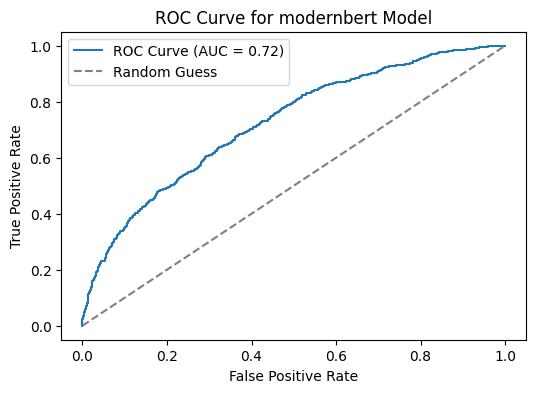

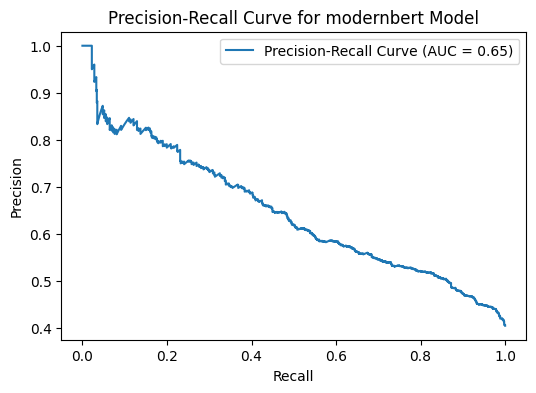

In [22]:
# Compute ROC curve
modernbert_fpr, modernbert_tpr, _ = roc_curve(y_true, y_scores)
modernbert_roc_auc = auc(modernbert_fpr, modernbert_tpr)

# Compute Precision-Recall curve
modernbert_precision, modernbert_recall, _ = precision_recall_curve(y_true, y_scores)
modernbert_auc_pr = auc(modernbert_recall, modernbert_precision)


# Plot ROC Curve
plt.figure(figsize=(6, 4))
plt.plot(modernbert_fpr, modernbert_tpr, label=f'ROC Curve (AUC = {modernbert_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guess')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for modernbert Model")
plt.legend()
plt.show()

# Plot Precision-Recall Curve
plt.figure(figsize=(6, 4))
plt.plot(modernbert_recall, modernbert_precision, label=f'Precision-Recall Curve (AUC = {modernbert_auc_pr:.2f})')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve for modernbert Model")
plt.legend()
plt.show()


In [23]:
# prompt: save all modernbert roc and prc related values as a json/dictionary file in drive

import json

# Create a dictionary to store the ROC and PRC values
modernbert_metrics = {
    "roc_fpr": modernbert_fpr.tolist(),
    "roc_tpr": modernbert_tpr.tolist(),
    "roc_auc": modernbert_roc_auc,
    "prc_precision": modernbert_precision.tolist(),
    "prc_recall": modernbert_recall.tolist(),
    "prc_auc": modernbert_auc_pr
}

# Specify the file path in your Google Drive
file_path = "/content/drive/Shareddrives/FYP 2024-2025/Phase-2/Lexical Bias Detection/Wiki/saved_models/ModernBERT.json"

# Save the dictionary as a JSON file
with open(file_path, "w") as f:
    json.dump(modernbert_metrics, f)


In [6]:
checkpoint = '/content/drive/Shareddrives/FYP 2024-2025/Phase-2/Lexical Bias Detection/Wiki/saved_models/DeBERTa'
deberta_tokenizer = AutoTokenizer.from_pretrained(checkpoint)
deberta_model = AutoModelForSequenceClassification.from_pretrained(checkpoint)

In [7]:
tokenized_test = test_dataset.map(partial(tokenize_function, input_col="sentence", hf_tokenizer=deberta_tokenizer), batched=True)

Map:   0%|          | 0/2104 [00:00<?, ? examples/s]

In [8]:
deberta_model.eval()
deberta_model.to('cuda')


DebertaV2ForSequenceClassification(
  (deberta): DebertaV2Model(
    (embeddings): DebertaV2Embeddings(
      (word_embeddings): Embedding(128100, 768, padding_idx=0)
      (LayerNorm): LayerNorm((768,), eps=1e-07, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): DebertaV2Encoder(
      (layer): ModuleList(
        (0-11): 12 x DebertaV2Layer(
          (attention): DebertaV2Attention(
            (self): DisentangledSelfAttention(
              (query_proj): Linear(in_features=768, out_features=768, bias=True)
              (key_proj): Linear(in_features=768, out_features=768, bias=True)
              (value_proj): Linear(in_features=768, out_features=768, bias=True)
              (pos_dropout): Dropout(p=0.1, inplace=False)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): DebertaV2SelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): Layer

In [9]:
# Extract labels and predictions
y_true = test_df['labels'].values
tokenized_inputs = {key: torch.tensor(val).to("cuda") for key, val in tokenized_test.to_dict().items() if key not in ["sentence", "labels"]}

with torch.no_grad():
    logits = deberta_model(**tokenized_inputs).logits.cpu().numpy()

y_scores = F.softmax(torch.tensor(logits), dim=1)[:, 1].numpy()

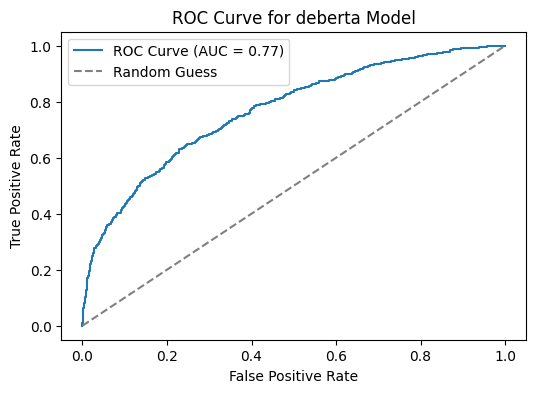

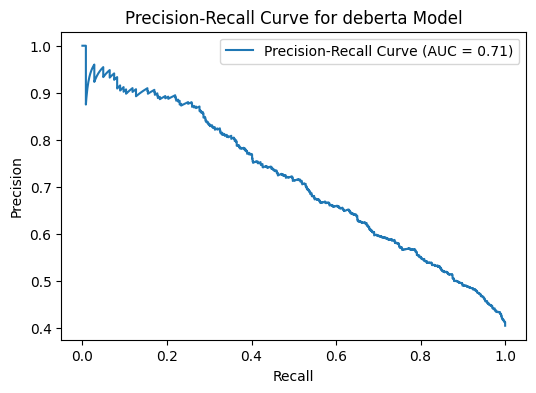

In [10]:
# Compute ROC curve
deberta_fpr, deberta_tpr, _ = roc_curve(y_true, y_scores)
deberta_roc_auc = auc(deberta_fpr, deberta_tpr)

# Compute Precision-Recall curve
deberta_precision, deberta_recall, _ = precision_recall_curve(y_true, y_scores)
deberta_auc_pr = auc(deberta_recall, deberta_precision)


# Plot ROC Curve
plt.figure(figsize=(6, 4))
plt.plot(deberta_fpr, deberta_tpr, label=f'ROC Curve (AUC = {deberta_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guess')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for deberta Model")
plt.legend()
plt.show()

# Plot Precision-Recall Curve
plt.figure(figsize=(6, 4))
plt.plot(deberta_recall, deberta_precision, label=f'Precision-Recall Curve (AUC = {deberta_auc_pr:.2f})')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve for deberta Model")
plt.legend()
plt.show()


In [11]:
# prompt: save all deberta roc and prc related values as a json/dictionary file in drive

import json

# Create a dictionary to store the ROC and PRC values
deberta_metrics = {
    "roc_fpr": deberta_fpr.tolist(),
    "roc_tpr": deberta_tpr.tolist(),
    "roc_auc": deberta_roc_auc,
    "prc_precision": deberta_precision.tolist(),
    "prc_recall": deberta_recall.tolist(),
    "prc_auc": deberta_auc_pr
}

# Specify the file path in your Google Drive
file_path = "/content/drive/Shareddrives/FYP 2024-2025/Phase-2/Lexical Bias Detection/Wiki/saved_models/DeBERTa.json"

# Save the dictionary as a JSON file
with open(file_path, "w") as f:
    json.dump(deberta_metrics, f)


In [15]:
with open("/content/drive/Shareddrives/FYP 2024-2025/Phase-2/Lexical Bias Detection/Wiki/saved_models/BERT.json", "r") as f:
    bert_metrics = json.load(f)

with open("/content/drive/Shareddrives/FYP 2024-2025/Phase-2/Lexical Bias Detection/Wiki/saved_models/RoBERTa.json", "r") as f:
    roberta_metrics = json.load(f)

with open("/content/drive/Shareddrives/FYP 2024-2025/Phase-2/Lexical Bias Detection/Wiki/saved_models/DistilBERT.json", "r") as f:
    distilbert_metrics = json.load(f)

with open("/content/drive/Shareddrives/FYP 2024-2025/Phase-2/Lexical Bias Detection/Wiki/saved_models/ModernBERT.json", "r") as f:
    modernbert_metrics = json.load(f)

with open("/content/drive/Shareddrives/FYP 2024-2025/Phase-2/Lexical Bias Detection/Wiki/saved_models/DeBERTa.json", "r") as f:
    deberta_metrics = json.load(f)

In [16]:
models_roc_prc = {
    'BERT': (bert_metrics['roc_fpr'], bert_metrics['roc_tpr'], bert_metrics['roc_auc'], bert_metrics['prc_precision'], bert_metrics['prc_recall'], bert_metrics['prc_auc']),
    'RoBERTa': (roberta_metrics['roc_fpr'], roberta_metrics['roc_tpr'], roberta_metrics['roc_auc'], roberta_metrics['prc_precision'], roberta_metrics['prc_recall'], roberta_metrics['prc_auc']),
    'DistilBERT': (distilbert_metrics['roc_fpr'], distilbert_metrics['roc_tpr'], distilbert_metrics['roc_auc'], distilbert_metrics['prc_precision'], distilbert_metrics['prc_recall'], distilbert_metrics['prc_auc']),
    'ModernBERT': (modernbert_metrics['roc_fpr'], modernbert_metrics['roc_tpr'], modernbert_metrics['roc_auc'], modernbert_metrics['prc_precision'], modernbert_metrics['prc_recall'], modernbert_metrics['prc_auc']),
    'DeBERTa': (deberta_metrics['roc_fpr'], deberta_metrics['roc_tpr'], deberta_metrics['roc_auc'], deberta_metrics['prc_precision'], deberta_metrics['prc_recall'], deberta_metrics['prc_auc'])
}

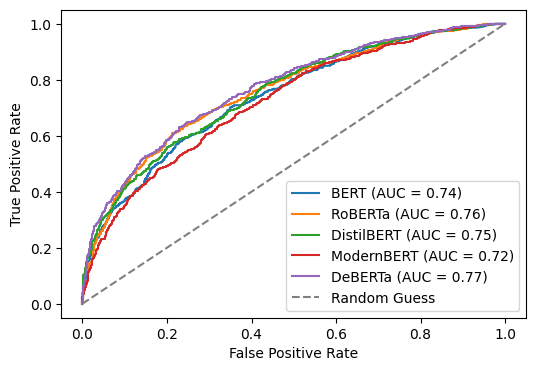

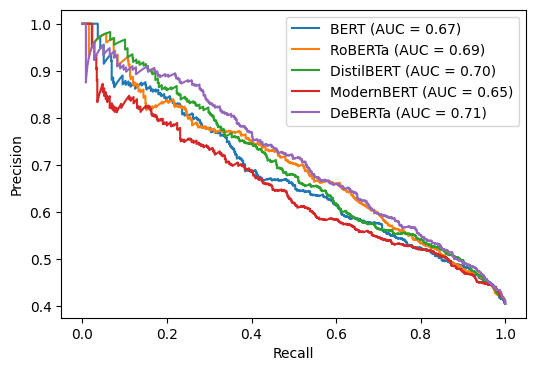

In [17]:
# Plot all together

# models_roc_prc = {
#     'BERT': (bert_fpr, bert_tpr, bert_roc_auc, bert_precision, bert_recall, bert_auc_pr),
#     'RoBERTa': (roberta_fpr, roberta_tpr, roberta_roc_auc, roberta_precision, roberta_recall, roberta_auc_pr),
#     'DistilBERT': (distilbert_fpr, distilbert_tpr, distilbert_roc_auc, distilbert_precision, distilbert_recall, distilbert_auc_pr),
#     'ModernBERT': (modernbert_fpr, modernbert_tpr, modernbert_roc_auc, modernbert_precision, modernbert_recall, modernbert_auc_pr),
#     'DeBERTa': (deberta_fpr, deberta_tpr, deberta_roc_auc, deberta_precision, deberta_recall, deberta_auc_pr)
# }


# Plot ROC Curves for all models
plt.figure(figsize=(6, 4))
for model, (fpr, tpr, roc_auc, _, _, _) in models_roc_prc.items():
    plt.plot(fpr, tpr, label=f'{model} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guess')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
# plt.title("ROC Curves for All Models")
plt.legend()
plt.show()

# Plot Precision-Recall Curves for all models
plt.figure(figsize=(6, 4))
for model, (_, _, _, precision, recall, auc_pr) in models_roc_prc.items():
    plt.plot(recall, precision, label=f'{model} (AUC = {auc_pr:.2f})')

plt.xlabel("Recall")
plt.ylabel("Precision")
# plt.title("Precision-Recall Curves for All Models")
plt.legend()
plt.show()



In [9]:
from transformers import AutoModel
checkpoint = '/content/drive/Shareddrives/FYP 2024-2025/Phase-2/Lexical Bias Detection/Wiki/saved_models/RoBERTa'
roberta_tokenizer = AutoTokenizer.from_pretrained(checkpoint)
roberta_model = AutoModel.from_pretrained(checkpoint)

tokenized_test = test_dataset.map(partial(tokenize_function, input_col="sentence", hf_tokenizer=roberta_tokenizer), batched=True)
tokenized_inputs = {key: torch.tensor(val).to("cuda") for key, val in tokenized_test.to_dict().items() if key not in ["sentence", "labels"]}

Some weights of RobertaModel were not initialized from the model checkpoint at /content/drive/Shareddrives/FYP 2024-2025/Phase-2/Lexical Bias Detection/Wiki/saved_models/RoBERTa and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/2104 [00:00<?, ? examples/s]

In [13]:
y_true = test_df['labels'].values

In [10]:
roberta_model.to("cuda")

RobertaModel(
  (embeddings): RobertaEmbeddings(
    (word_embeddings): Embedding(50265, 768, padding_idx=1)
    (position_embeddings): Embedding(514, 768, padding_idx=1)
    (token_type_embeddings): Embedding(1, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): RobertaEncoder(
    (layer): ModuleList(
      (0-11): 12 x RobertaLayer(
        (attention): RobertaAttention(
          (self): RobertaSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): RobertaSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (dr

In [11]:
import seaborn as sns

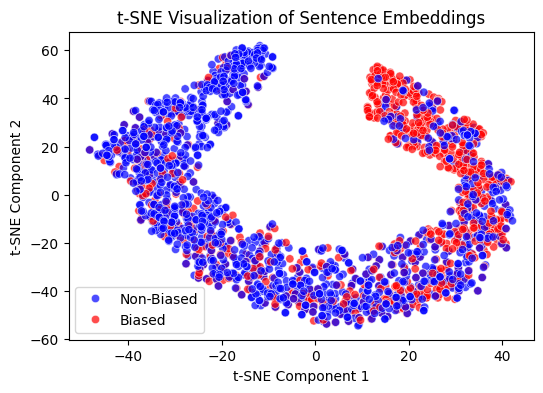

In [14]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Extract embeddings for visualization
with torch.no_grad():
    embeddings = roberta_model(**tokenized_inputs).last_hidden_state[:, 0, :].cpu().numpy()

# Reduce dimensions using PCA and t-SNE
pca = PCA(n_components=50)
embeddings_pca = pca.fit_transform(embeddings)

# Further reduce dimensions using t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
embeddings_tsne = tsne.fit_transform(embeddings_pca)

# Plot t-SNE visualization
plt.figure(figsize=(6, 4))
sns.scatterplot(x=embeddings_tsne[:, 0], y=embeddings_tsne[:, 1], hue=y_true, palette=['blue', 'red'], alpha=0.7)
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.title("t-SNE Visualization of Sentence Embeddings")
handles, _ = plt.gca().get_legend_handles_labels()
plt.legend(handles=handles, labels=["Non-Biased", "Biased"])
plt.show()